# Sequence-to-Sequence Model with Attention

Seq2seq models are used for applications such as machine translation and image caption generation.

We will build a seq2seq model with attention in PyTorch for translating English to French.

- [Visualizing A Neural Machine Translation Model (Mechanics of Seq2seq Models With Attention)](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/): A great blog post to learn seq2seq model with attention wth visual explanations.

In [0]:
# Install extra requirements
!pip install googledrivedownloader ipdb -q

In [0]:
import itertools
from collections import Counter
from functools import partial
from pathlib import Path

import numpy as np
import torch
import pandas as pd
from nltk import wordpunct_tokenize
from tqdm import tqdm_notebook, tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data.dataset import random_split
from torch.nn.utils.rnn import (
    pack_padded_sequence, pad_packed_sequence, pad_sequence,
)
from google_drive_downloader import GoogleDriveDownloader as gdd

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.style.use('ggplot')

tqdm.pandas()

# Show better CUDA error messages
!export CUDA_LAUNCH_BLOCKING=1

In order to perform deep learning on a GPU (so that everything runs super quick!), CUDA has to be installed and configured. Fortunately, Google Colab already has this set up, but if you want to try this on your own GPU, you can [install CUDA from here](https://developer.nvidia.com/cuda-downloads). Make sure you also [install cuDNN](https://developer.nvidia.com/cudnn) for optimized performance.

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Download the data

We will download a dataset of English-to-French translations from a public Google Drive folder.

In [0]:
DATA_PATH = 'data/english_to_french.txt'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id='1Jf7QoW2NK6_ayEXZji6DAXDSIRMvapm3',
        dest_path=DATA_PATH,
    )

## Data preparation

Unfortunately for most data scientists, a lot of work has to go into data preparation. If the data isn't good, the model won't be any better.

![tesla](https://electrek.co/wp-content/uploads/sites/3/2018/06/screen-shot-2018-06-11-at-6-20-34-am.jpg?resize=1024,553)
(source: slide by Andrej Karpathy (?))

In PyTorch, it is customary to define a class to store all of your data in. We inherit from `torch.utils.data.Dataset`; however, this is a very simple class. In fact, the class is so simple I could just print it here:


```python
class Dataset(object):
    """An abstract class representing a Dataset.
    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```

Classes that inherit from `Dataset` just need to implement `__getitem__` and `__len__`. What's nice about using this class also is that you can use other PyTorch functions like `torch.utils.data.DataLoader` in order to turn your dataset into training batches. But more on that later.

`__getitem__` will pass an index and expect an example at that index. `__len__` expects you to return the length of your data, ie. how many examples you have.

In [0]:
class EnglishFrenchTranslations(Dataset):
    def __init__(self, path, max_vocab):
        self.max_vocab = max_vocab
        
        # Extra tokens to add
        self.padding_token = '<PAD>'
        self.start_of_sequence_token = '<SOS>'
        self.end_of_sequence_token = '<EOS>'
        self.unknown_word_token = '<UNK>'
        
        # Helper function
        self.flatten = lambda x: [sublst for lst in x for sublst in lst]
        
        # Load the data into a DataFrame
        df = pd.read_csv(path, names=['english', 'french'], sep='\t')
        
        # Tokenize inputs (English) and targets (French)
        self.tokenize_df(df)

        # To reduce computational complexity, replace rare words with <UNK>
        self.replace_rare_tokens(df)
        
        # Prepare variables with mappings of tokens to indices
        self.create_token2idx(df)
        
        # Remove sequences with mostly <UNK>
        df = self.remove_mostly_unk(df)
        
        # Every sequence (input and target) should start with <SOS>
        # and end with <EOS>
        self.add_start_and_end_to_tokens(df)
        
        # Convert tokens to indices
        self.tokens_to_indices(df)
        
    def __getitem__(self, idx):
        """Return example at index idx."""
        return self.indices_pairs[idx][0], self.indices_pairs[idx][1]
    
    def tokenize_df(self, df):
        """Turn inputs and targets into tokens."""
        df['tokens_inputs'] = df.english.apply(
            EnglishFrenchTranslations.tokenize,
        )
        df['tokens_targets'] = df.french.apply(
            EnglishFrenchTranslations.tokenize,
        )
        
    @staticmethod
    def tokenize(text):
        """Turn text into discrete tokens.

        Remove tokens that are not words.
        """
        text = text.lower()
        tokens = wordpunct_tokenize(text)

        # Only keep words
        tokens = [token for token in tokens
                  if all(char.isalpha() for char in token)]

        return tokens
        
    def replace_rare_tokens(self, df):
        """Replace rare tokens with <UNK>."""
        common_tokens_inputs = self.get_most_common_tokens(
            df.tokens_inputs.tolist(),
        )
        common_tokens_targets = self.get_most_common_tokens(
            df.tokens_targets.tolist(),
        )
        
        df.loc[:, 'tokens_inputs'] = df.tokens_inputs.apply(
            lambda tokens: [token if token in common_tokens_inputs 
                            else self.unknown_word_token for token in tokens]
        )
        df.loc[:, 'tokens_targets'] = df.tokens_targets.apply(
            lambda tokens: [token if token in common_tokens_targets
                            else self.unknown_word_token for token in tokens]
        )

    def get_most_common_tokens(self, tokens_series):
        """Return the max_vocab most common tokens."""
        all_tokens = self.flatten(tokens_series)
        # Substract 4 for <PAD>, <SOS>, <EOS>, and <UNK>
        common_tokens = set(list(zip(*Counter(all_tokens).most_common(
            self.max_vocab - 4)))[0])
        return common_tokens
    
    
    def remove_mostly_unk(self, df, threshold=0.99):
        """Remove sequences with mostly <UNK>."""
        calculate_ratio = (
            lambda tokens: sum(1 for token in tokens if token != '<UNK>')
            / len(tokens) > threshold
        )
        df = df[df.tokens_inputs.progress_apply(calculate_ratio)]
        df = df[df.tokens_targets.progress_apply(calculate_ratio)]
        return df
        
    def create_token2idx(self, df):
        """Create variables with mappings from tokens to indices."""
        unique_tokens_inputs = set(self.flatten(df.tokens_inputs))
        unique_tokens_targets = set(self.flatten(df.tokens_targets))
        
        for token in reversed([
            self.padding_token,
            self.start_of_sequence_token,
            self.end_of_sequence_token,
            self.unknown_word_token,
        ]):
            if token in unique_tokens_inputs:
                unique_tokens_inputs.remove(token)
            if token in unique_tokens_targets:
                unique_tokens_targets.remove(token)
                
        unique_tokens_inputs = sorted(list(unique_tokens_inputs))
        unique_tokens_targets = sorted(list(unique_tokens_targets))

        # Add <PAD>, <SOS>, <EOS>, and <UNK> tokens
        for token in reversed([
            self.padding_token,
            self.start_of_sequence_token,
            self.end_of_sequence_token,
            self.unknown_word_token,
        ]):
            
            unique_tokens_inputs = [token] + unique_tokens_inputs
            unique_tokens_targets = [token] + unique_tokens_targets
            
        self.token2idx_inputs = {token: idx for idx, token
                                 in enumerate(unique_tokens_inputs)}
        self.idx2token_inputs = {idx: token for token, idx
                                 in self.token2idx_inputs.items()}
        
        self.token2idx_targets = {token: idx for idx, token
                                  in enumerate(unique_tokens_targets)}
        self.idx2token_targets = {idx: token for token, idx
                                  in self.token2idx_targets.items()}
        
    def add_start_and_end_to_tokens(self, df):
        """Add <SOS> and <EOS> tokens to the end of every input and output."""
        df.loc[:, 'tokens_inputs'] = (
            [self.start_of_sequence_token]
            + df.tokens_inputs
            + [self.end_of_sequence_token]
        )
        df.loc[:, 'tokens_targets'] = (
            [self.start_of_sequence_token]
            + df.tokens_targets
            + [self.end_of_sequence_token]
        )
        
    def tokens_to_indices(self, df):
        """Convert tokens to indices."""
        df['indices_inputs'] = df.tokens_inputs.apply(
            lambda tokens: [self.token2idx_inputs[token] for token in tokens])
        df['indices_targets'] = df.tokens_targets.apply(
            lambda tokens: [self.token2idx_targets[token] for token in tokens])
             
        self.indices_pairs = list(zip(df.indices_inputs, df.indices_targets))
        
    def __len__(self):
        return len(self.indices_pairs)

In [0]:
#@title Load data
max_vocab = 1000  #@param {type: "integer"}

dataset = EnglishFrenchTranslations(DATA_PATH, max_vocab=max_vocab)
len(dataset)

100%|██████████| 77040/77040 [00:00<00:00, 311829.42it/s]


40288

### Split dataset into train, validation, and test

![train-validation-test](https://cdn-images-1.medium.com/max/800/1*obKmc_bTKbUFgcgryhaAnA.png)

([source](https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9))


In [0]:
#@title Train, validation, and test

def split_train_valid_test(corpus, valid_ratio=0.1, test_ratio=0.1):
    """Split dataset into train, validation, and test."""
    test_length = int(len(corpus) * test_ratio)
    valid_length = int(len(corpus) * valid_ratio)
    train_length = len(corpus) - valid_length - test_length
    return random_split(
        corpus, lengths=[train_length, valid_length, test_length],
    )

valid_ratio = 0.05  #@param {type:"slider", min:0.01, max:0.3, step:0.01}
test_ratio = 0.001  #@param {type:"slider", min:0.001, max:0.3, step:0.01}

train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset,
    valid_ratio=valid_ratio,
    test_ratio=test_ratio,
)
len(train_dataset), len(valid_dataset), len(test_dataset)

(38234, 2014, 40)

### Create data generators using `DataLoader`

In [0]:
#@title Generate batches

def collate(batch):
    inputs = [torch.LongTensor(item[0]) for item in batch]
    targets = [torch.LongTensor(item[1]) for item in batch]
    
    # Pad sequencse so that they are all the same length (within one minibatch)
    padded_inputs = pad_sequence(inputs, padding_value=dataset.token2idx_targets[dataset.padding_token], batch_first=True)
    padded_targets = pad_sequence(targets, padding_value=dataset.token2idx_targets[dataset.padding_token], batch_first=True)
    
    # Sort by length for CUDA optimizations
    lengths = torch.LongTensor([len(x) for x in inputs])
    lengths, permutation = lengths.sort(dim=0, descending=True)

    return padded_inputs[permutation].to(device), padded_targets[permutation].to(device), lengths.to(device)

# Powers of two are preferred for optimal usage on the GPU
batch_size = 512  #@param {type:"integer"}

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=1, collate_fn=collate)

## Model Architecture

![seq2seq diagram](https://cdn-images-1.medium.com/max/800/1*_rSHLjFShknAu3jt3rbcNQ.png)
([source](https://towardsdatascience.com/seq2seq-model-in-tensorflow-ec0c557e560f))

### Define the Encoder

In [0]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = nn.GRU(
            self.embedding_dim,
            self.hidden_size,
            batch_first=True,
        )
        
    def forward(self, inputs, lengths):
        # Turn input indices into distributed embeddings
        x = self.embedding(inputs)

        # Remove padding for more efficient RNN application
        x = pack_padded_sequence(x, lengths, batch_first=True)
    
        # Apply RNN to get hidden state at all timesteps (output)
        # and hidden state of last output (self.hidden)
        output, self.hidden = self.gru(x, self.init_hidden())
        
        # Pad the sequences like they were before
        output, _ = pad_packed_sequence(output)
        
        return output, self.hidden

    def init_hidden(self):
        # Randomly initialize the weights of the RNN
        return torch.randn((1, self.batch_size, self.hidden_size)).to(device)

### Define the Decoder

In [0]:
class Decoder(nn.Module):
    def __init__(
        self, 
        vocab_size,
        embedding_dim, 
        decoder_hidden_size,
        encoder_hidden_size, 
        batch_size,
    ):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = nn.GRU(
            self.embedding_dim + self.encoder_hidden_size, 
            self.decoder_hidden_size,
            batch_first=True,
        )
        self.fc = nn.Linear(self.encoder_hidden_size, self.vocab_size)
        
        # Attention weights
        self.W1 = nn.Linear(self.encoder_hidden_size, self.decoder_hidden_size)
        self.W2 = nn.Linear(self.encoder_hidden_size, self.decoder_hidden_size)
        self.V = nn.Linear(self.encoder_hidden_size, 1)
    
    def forward(self, targets, hidden, encoder_output):
        # Switch the dimensions of sequence_length and batch_size
        encoder_output = encoder_output.permute(1, 0, 2)

        # Add an extra axis for a time dimension
        hidden_with_time_axis = hidden.permute(1, 0, 2)
        
        # Attention score (Bahdanaus)
        score = torch.tanh(self.W1(encoder_output) + self.W2(hidden_with_time_axis))

        # Attention weights
        attention_weights = torch.softmax(self.V(score), dim=1)
        
        # Find the context vectors
        context_vector = attention_weights * encoder_output
        context_vector = torch.sum(context_vector, dim=1)
        
        # Turn target indices into distributed embeddings
        x = self.embedding(targets)
        
        # Add the context representation to the target embeddings
        x = torch.cat((context_vector.unsqueeze(1), x), -1)
        
        # Apply the RNN
        output, state = self.gru(x, self.init_hidden())
        
        # Reshape the hidden states (output)
        output = output.view(-1, output.size(2))
        
        # Apply a linear layer
        x = self.fc(output)
        
        return x, state, attention_weights
    
    def init_hidden(self):
        # Randomly initialize the weights of the RNN
        return torch.randn((1, self.batch_size, self.decoder_hidden_size)).to(device)

### Define a model that has both an Encoder and Decoder

In [0]:
criterion = nn.CrossEntropyLoss()

def loss_function(real, pred):
    """Calculate how wrong the model is."""
    # Use mask to only consider non-zero inputs in the loss
    mask = real.ge(1).float().to(device)
    
    loss_ = criterion(pred, real) * mask 
    return torch.mean(loss_)


class EncoderDecoder(nn.Module):
    def __init__(
        self,
        inputs_vocab_size, 
        targets_vocab_size, 
        hidden_size,
        embedding_dim, 
        batch_size,
        targets_start_idx,
        targets_stop_idx,
    ):
        super(EncoderDecoder, self).__init__()
        self.batch_size = batch_size
        self.targets_start_idx = targets_start_idx
        self.targets_stop_idx = targets_stop_idx
        
        self.encoder = Encoder(
            inputs_vocab_size,
            embedding_dim,
            hidden_size,
            batch_size,
        ).to(device)
        
        self.decoder = Decoder(
            targets_vocab_size,
            embedding_dim,
            hidden_size,
            hidden_size,
            batch_size,
        ).to(device)
        
    def forward(self, inputs, targets, lengths, predict=False):
        encoder_output, encoder_hidden = self.encoder(
            inputs.to(device),
            lengths,
        )
        decoder_hidden = encoder_hidden
        
        # Initialize the input of the decoder to be <SOS>
        decoder_input = torch.LongTensor(
            [[self.targets_start_idx]] * self.batch_size,
        )
        
        if predict:
            # Output predictions instead of loss
            output = []
            for _ in range(20):
                predictions, decoder_hidden, _ = self.decoder(
                    decoder_input.to(device), 
                    decoder_hidden.to(device),
                    encoder_output.to(device),
                )
                prediction = torch.multinomial(F.softmax(predictions, dim=1), 1)
                decoder_input = prediction

                prediction = prediction.item()
                output.append(prediction)
                
                if prediction == self.targets_stop_idx:
                    return output

            return output
                
        # Use teacher forcing to train the model. Instead of feeding the model's
        # own predictions to itself, feed the target token at every timestep.
        # This leads to faster convergence
        loss = 0
        for timestep in range(1, targets.size(1)):
            predictions, decoder_hidden, _ = self.decoder(
                decoder_input.to(device), 
                decoder_hidden.to(device),
                encoder_output.to(device),
            )
            decoder_input = targets[:, timestep].unsqueeze(1)
            
            loss += loss_function(targets[:, timestep], predictions)
            
        return loss / targets.size(1)

In [0]:
def train_epoch(model, optimizer, scheduler, train_loader):
    model.train()
    total_loss = total = 0
    progress_bar = tqdm_notebook(train_loader, desc='Training', leave=False)
    for inputs, targets, lengths in progress_bar:
        # Clean old gradients
        optimizer.zero_grad()

        # Forwards pass
        loss = model(inputs, targets, lengths)

        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        scheduler.step()

        # Record metrics
        total_loss += loss.item()
        total += targets.size(1)

    return total_loss / total


def validate_epoch(model, valid_loader):
    model.eval()
    total_loss = total = 0
    with torch.no_grad():
        progress_bar = tqdm_notebook(valid_loader, desc='Validating', leave=False)
        for inputs, targets, lengths in progress_bar:
            # Forwards pass
            loss = model(inputs, targets, lengths)

            # Record metrics
            total_loss += loss.item()
            total += targets.size(1)

    return total_loss / total

In [0]:
inputs_vocab_size = len(dataset.token2idx_inputs)
targets_vocab_size = len(dataset.token2idx_targets)
targets_start_idx = dataset.token2idx_targets[dataset.start_of_sequence_token]
targets_stop_idx = dataset.token2idx_targets[dataset.end_of_sequence_token]

hidden_size = 128  #@param {type:"integer"}
embedding_dim = 128  #@param {type:"integer"}
learning_rate = 0.001  #@param {type:"number"}
max_epochs = 50  #@param {type:"integer"}

# Instantiate a model to train
model = EncoderDecoder(
    inputs_vocab_size,
    targets_vocab_size,
    hidden_size, 
    embedding_dim, 
    batch_size, 
    targets_start_idx, 
    targets_stop_idx,
).to(device)

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate,
)
scheduler = CosineAnnealingLR(optimizer, 1)

# Training loop
n_epochs = 0
train_losses, valid_losses = [], []
for _ in range(max_epochs):
    train_loss = train_epoch(model, optimizer, scheduler, train_loader)
    valid_loss = validate_epoch(model, valid_loader)
    
    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}'
        f'\tvalid_loss: {valid_loss:.2e}\n',
    )
    
    # Early stopping if the current valid_loss is greater than the
    # last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss
                                     for loss in valid_losses[-3:]):
        print('Stopping early')
        break
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    n_epochs += 1

epoch #  1	train_loss: 9.55e-02	valid_loss: 8.61e-02



epoch #  2	train_loss: 7.34e-02	valid_loss: 7.86e-02



epoch #  3	train_loss: 6.74e-02	valid_loss: 7.22e-02



epoch #  4	train_loss: 6.17e-02	valid_loss: 6.60e-02



epoch #  5	train_loss: 5.60e-02	valid_loss: 5.97e-02



epoch #  6	train_loss: 5.06e-02	valid_loss: 5.43e-02



epoch #  7	train_loss: 4.60e-02	valid_loss: 4.96e-02



epoch #  8	train_loss: 4.20e-02	valid_loss: 4.58e-02



epoch #  9	train_loss: 3.88e-02	valid_loss: 4.29e-02



epoch # 10	train_loss: 3.60e-02	valid_loss: 4.02e-02



epoch # 11	train_loss: 3.36e-02	valid_loss: 3.83e-02



epoch # 12	train_loss: 3.16e-02	valid_loss: 3.61e-02



epoch # 13	train_loss: 2.99e-02	valid_loss: 3.45e-02



epoch # 14	train_loss: 2.82e-02	valid_loss: 3.26e-02



epoch # 15	train_loss: 2.67e-02	valid_loss: 3.12e-02



epoch # 16	train_loss: 2.54e-02	valid_loss: 3.02e-02



epoch # 17	train_loss: 2.44e-02	valid_loss: 2.90e-02



epoch # 18	train_loss: 2.36e-02	valid_loss: 2.80e-02



epoch # 19	train_loss: 2.24e-02	valid_loss: 2.72e-02



epoch # 20	train_loss: 2.16e-02	valid_loss: 2.64e-02



epoch # 21	train_loss: 2.08e-02	valid_loss: 2.58e-02



epoch # 22	train_loss: 2.01e-02	valid_loss: 2.52e-02



epoch # 23	train_loss: 1.95e-02	valid_loss: 2.48e-02



epoch # 24	train_loss: 1.89e-02	valid_loss: 2.46e-02



epoch # 25	train_loss: 1.84e-02	valid_loss: 2.48e-02



epoch # 26	train_loss: 1.81e-02	valid_loss: 2.36e-02



epoch # 27	train_loss: 1.82e-02	valid_loss: 2.30e-02



epoch # 28	train_loss: 1.75e-02	valid_loss: 2.33e-02



epoch # 29	train_loss: 1.70e-02	valid_loss: 2.29e-02



epoch # 30	train_loss: 1.65e-02	valid_loss: 2.23e-02



epoch # 31	train_loss: 1.62e-02	valid_loss: 2.20e-02



epoch # 32	train_loss: 1.60e-02	valid_loss: 2.18e-02



epoch # 33	train_loss: 1.59e-02	valid_loss: 2.13e-02



epoch # 34	train_loss: 1.57e-02	valid_loss: 2.11e-02



epoch # 35	train_loss: 1.52e-02	valid_loss: 2.09e-02



epoch # 36	train_loss: 1.47e-02	valid_loss: 2.07e-02



epoch # 37	train_loss: 1.44e-02	valid_loss: 2.06e-02



epoch # 38	train_loss: 1.42e-02	valid_loss: 2.05e-02



epoch # 39	train_loss: 1.40e-02	valid_loss: 2.03e-02



epoch # 40	train_loss: 1.37e-02	valid_loss: 2.02e-02



epoch # 41	train_loss: 1.35e-02	valid_loss: 2.01e-02



epoch # 42	train_loss: 1.34e-02	valid_loss: 2.00e-02



epoch # 43	train_loss: 1.33e-02	valid_loss: 2.03e-02

Stopping early


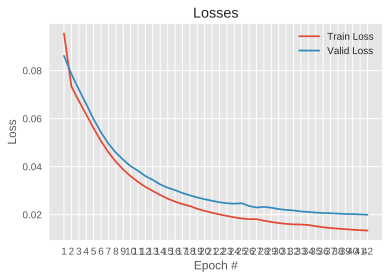

In [0]:
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

In [0]:
torch.save(model.state_dict(), 'model.pkl')

In [0]:
model = EncoderDecoder(
    inputs_vocab_size, 
    targets_vocab_size, 
    hidden_size, 
    embedding_dim,
    1,
    targets_start_idx,
    targets_stop_idx,
).to(device)
model.load_state_dict(torch.load('model.pkl'))

In [0]:
model.eval()
total_loss = total = 0
with torch.no_grad():
    for inputs, targets, lengths in test_loader:
        print('>', ' '.join([
            dataset.idx2token_inputs[idx]
            for idx in inputs.cpu()[0].numpy()[1:-1]
        ]))

        # Forwards pass
        outputs = model(inputs, targets, lengths, predict=True)
        print(' '.join([
            dataset.idx2token_targets[idx]
            for idx in outputs[:-1]
        ]))
        
        print()

> you haven t eaten anything yet have you
tu n a rien ouvert quoi on n as rien entendu le moindre idée de neige quoi vous avoir

> i ll leave that to you
je te laisse entrer

> i think i see something
je pense que j ai à se sentir quelque chose

> i m glad to see you re happy
je suis content de vous voir heureux

> are you afraid of death
en êtes vous peur de la mort

> don t stop him
ne lui mettre l arrêter

> please make the bed
si fort bien mettre au lit

> you re all alone
tu es tout seul

> he had no coat on
il n ont jamais plus sur pieds

> tom couldn t have done it without mary s help
tom n a pas pu le faire sans mary pour t il d aide à marie il d arriver

> that is not true
ce ne le n est pas vrai

> i can do this with you or without you
je ne veux faire ceci avec ou venir

> she advised him to drink more milk
elle lui a conseillé d un serait plus rappeler à court

> i ve read all about you
j ai lu tout à vous de toi

> there s a table
qu il y a beaucoup près des erreurs

> you